# RandomForest 분류 기본 코드

의사결정트리를 사용하는 가장 대표적인 배깅 모델

의사결정트리의 단점(과적합이 자주 발생)을 보완하고 장점은 유지한다.

최근 XGBoost, LightGBM, CatBoost와 함께 주목받는 알고리즘 중 하나.

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# RandomForest 분류기
from sklearn.ensemble import RandomForestClassifier

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 기본 전처리

In [3]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 결과확인
total_count = len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


### [4] 훈련/검증 데이터 분리 및 스케일링

In [4]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'Outcome', scalling=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


## #02. 랜덤포레스트 분류모형 생성

| 하이퍼파라미터         | 설명                           | 기본값     | 추천사항                                          |
|---------------------|------------------------------|---------|-------------------------------------------------|
| `n_estimators`      | 결정 트리의 수                   | `100`   | 더 많은 트리는 성능 개선 가능, 계산 비용 고려 필요             |
| `criterion`         | 노드 분할 품질 측정 기준              | `"gini"` | `"gini"`, `"entropy"`, `"log_loss"` 중 선택, 실험을 통해 결정 권장       |
| `max_depth`         | 트리 최대 깊이                   | `None`  | 과적합 방지 위해 제한, 문제 복잡성에 따라 조정 필요            |
| `min_samples_split` | 내부 노드 분할 최소 샘플 수           | `2`     | 너무 낮으면 과적합, 너무 높으면 과소적합, 데이터 크기 고려 조정 필요 |
| `min_samples_leaf`  | 리프 노드 최소 샘플 수              | `1`     | 증가시킬 경우 일반화 증가 가능, 과소적합 주의                   |
| `max_features`      | 분할 시 고려 최대 특성 수            | `"sqrt"`| `"sqrt"`, `"log2"`, `None` 중 선택, 실험을 통해 결정 권장 |

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |            1 |     0.772727 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |            1 |     0.680851 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |            1 |     0.615385 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |            0 |     0.147059 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |            1 |     0.852941 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |            1 |     0.646465 | 정밀도와 재현율의 조화평균                                |
| AUC               |            1 |     0.810143 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

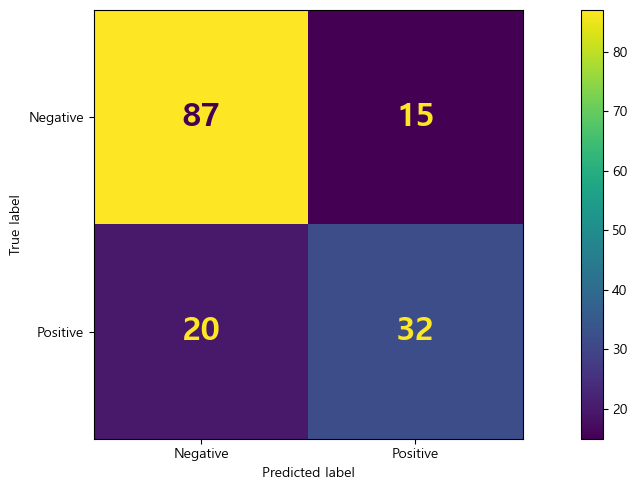


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


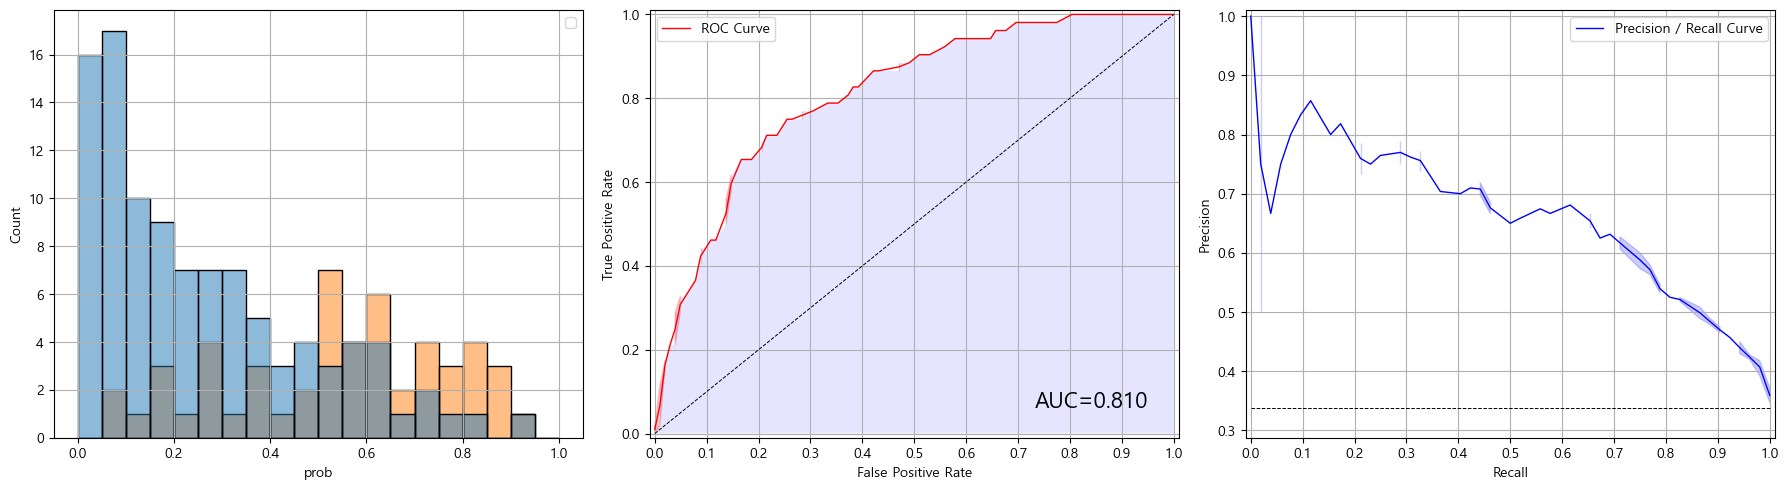


[학습곡선]


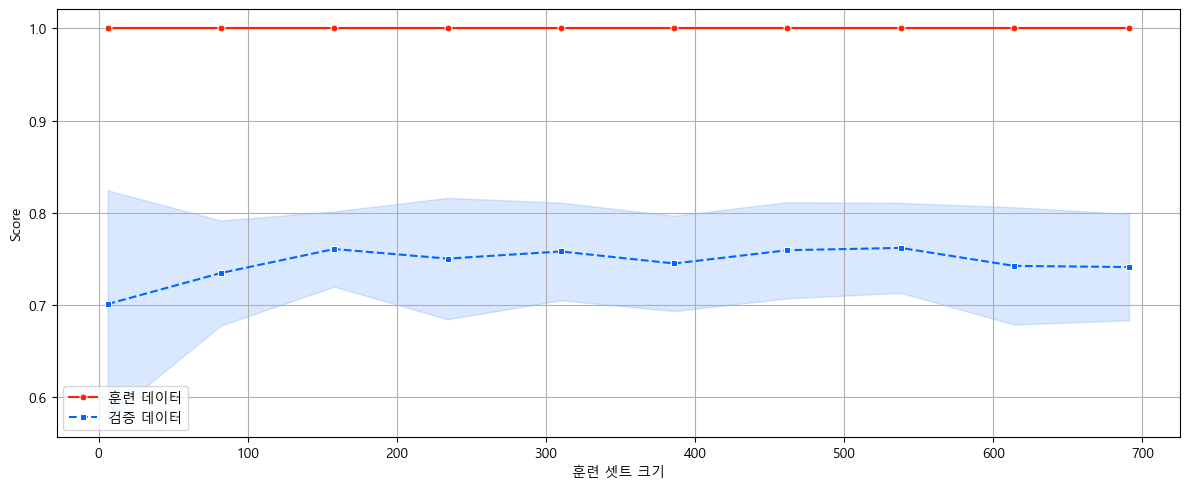

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.72987 |
|  1 | Outcome    | Glucose                  | 1.37433 |
|  2 | Outcome    | BloodPressure            | 1.39985 |
|  3 | Outcome    | SkinThickness            |  1.4874 |
|  4 | Outcome    | Insulin                  | 1.16212 |
|  5 | Outcome    | BMI                      | 1.76203 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.06232 |
|  7 | Outcome    | Age                      | 2.05027 |
+----+------------+--------------------------+---------+


In [5]:
estimator = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=get_random_state(),
    n_jobs=get_n_jobs(),
)

estimator.fit(x_train, y_train)

my_classification_result(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

my_classification_report(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)